## 知識情報学第13回演習サンプルプログラム ex13.ipynb
- Programmed by Nattapong Thammasan, 監修　福井健一
- Last updated: 2021/01/19
- Checked with Python 3.8, scikit-learn 0.24
- MIT License

## Label Spreadingによる半教師あり学習

In [1]:
import numpy as np
import copy
from sklearn.datasets import load_wine
from sklearn.preprocessing import scale
from sklearn.semi_supervised import LabelSpreading
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
wine = load_wine()
X = scale(wine.data)
y = wine.target

学習データの次元

In [3]:
X.shape

(178, 13)

In [4]:
y.shape

(178,)

In [5]:
from collections import Counter
Counter(y)

Counter({0: 59, 1: 71, 2: 48})

In [6]:
# 描画のためPCAで2次元に圧縮
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# クラス数 
n_class = len(np.unique(y)) # = 3

# 教師率
labeled_ratio = 0.1

### 乱数を用いて教師なしデータを生成する関数
- 教師なしデータのラベルを-1とする

In [7]:
def set_unlabeled_data(y_org, labeled_ratio):
    y1 = copy.copy(y_org)
    for i in range(len(y_org)):
        if(np.random.random()>labeled_ratio):
            y1[i] = -1
    return y1

### LabelSpreading

In [8]:
y_semi = set_unlabeled_data(y, labeled_ratio)

ls = LabelSpreading(kernel='knn', n_neighbors=10, alpha=0.1)
ls.fit(X_pca, y_semi)

# プロットに使用する推定ラベルを保存
y_pred = ls.predict(X_pca)

# 全データに対するAccuracyの算出
acc = ls.score(X_pca, y)
print("Accuracy: %.4f" % acc)

Accuracy: 0.9663


### LabelSpreadingの結果のプロット

In [9]:
def plot_ssl(y_pred, y_semi):
    colors = (["lightgreen", "orange", "lightblue", "m", "b", "g", "c", "y", "w", "k"])
    markers = (["s", "o", "v", "^", "D", ">", "<", "d", "p", "H"])

    plt.figure(figsize=(30,8))
    plt.subplot(131)
    for c in range(-1,n_class):
        if(c == -1):
            cls_label = 'unlabeled'
        else:
            cls_label = 'class'+str(c+1)
        plt.scatter(X_pca[y_semi==c, 0],
                    X_pca[y_semi==c, 1],
                    s=50,
                    c=colors[c],
                    marker=markers[c],
                    label= cls_label)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title("Original Data")
    plt.legend()
    plt.grid()

    plt.subplot(132)
    for c in range(0,n_class):
        plt.scatter(X_pca[y_pred==c, 0],
                    X_pca[y_pred==c, 1],
                    s=50,
                    c=colors[c],
                    marker=markers[c],
                    label="class " + str(c+1))

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title("Labels learned with Label Spreading")
    plt.legend()
    plt.grid()

    plt.subplot(133)
    for c in range(0,n_class):
        plt.scatter(X_pca[y==c, 0],
                    X_pca[y==c, 1],
                    s=50,
                    c=colors[c],
                    marker=markers[c],
                    label="class " + str(c+1))

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title("Ground Truth label")
    plt.legend()
    plt.grid()
    plt.show()

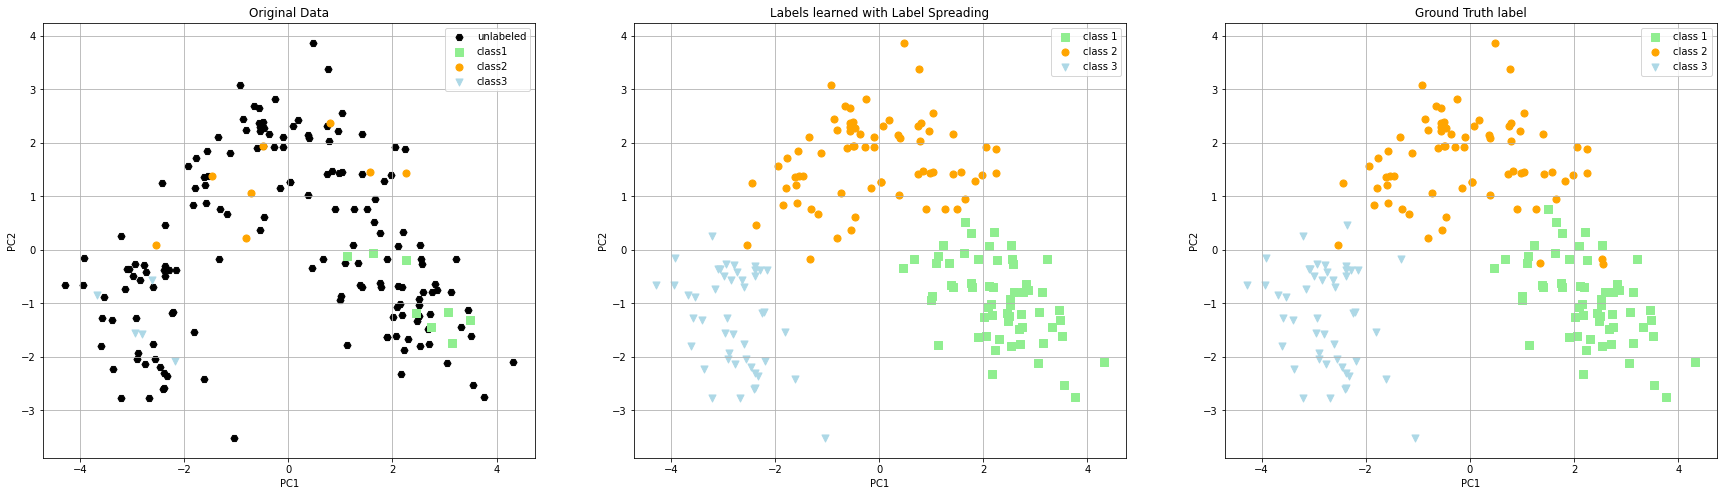

In [10]:
plot_ssl(y_pred, y_semi)

### 課題1(a). 教師率を変化させたときのAccuracy
- 全特徴量を使用すること
- データ数が少ないため，学習データに対するAccuracyで良い
- ヒント：異なる乱数による結果の平均を用いると良い

各教師ラベルの割合に対して正答率を計算する実験を50回行った際の平均をプロットする

In [11]:
num_trial = 50
mean_accs = []
ratio_list = np.linspace(0.04,1)
for labeled_ratio in ratio_list:
    mean_acc = []
    for _ in range(num_trial):        
        y_semi = set_unlabeled_data(y, labeled_ratio)
        ls = LabelSpreading(kernel='knn', n_neighbors=10, alpha=0.1)
        ls.fit(X_pca, y_semi)
        y_pred = ls.predict(X_pca)
        acc = ls.score(X_pca, y)
        mean_acc.append(acc)
    mean_accs.append(np.array(mean_acc).mean())

Text(0.5, 1.0, 'accuracy transition with labeled data num')

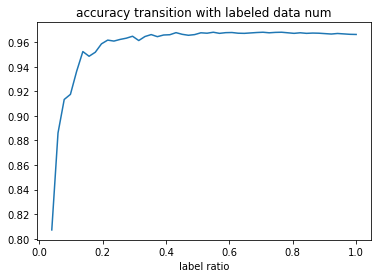

In [12]:
plt.plot(ratio_list, mean_accs)
plt.xlabel('label ratio')
plt.title("accuracy transition with labeled data num")

In [13]:
print(ratio_list[-1])
print(mean_accs[-1])

1.0
0.9662921348314607


グラフよりラベル付けされていない"unlabeled"が少なくなるにつれて正答率も高くなっていることがわかる．  
また何もラベルが隠されていない際にknnで予測した結果は上のように96%程度の性能を持つことがわかる(ベースライン)．  
グラフより，データを間引く方が汎化性能が良くなるなどの結果は得られておらず，学習データの増加とともに性能も単調に増加するという直感にあった結果が得られた．  

### 課題1(b). Clamping Factor を変化させたときのAccuracy

Clamping Factorは講義資料で言うところの$\mu$にあたり，どの程度元のラベルの重要度を考慮するかのパラメータとなっている．  
つまり$\mu \rightarrow \infty$では元々のラベルに絶対に合うように学習が行われることになる．  
sklearnの実装では相対的な値となっているので$\alpha \in (0,1)$で選択する．  
ここで$\alpha = 0$は全てのラベルを保持することを表し，$\alpha = 1$は教師データのラベルを考慮しないことを表す．  
今回は1000回の実験の平均値で性能を測定する.

In [14]:
num_trial = 100
mean_accs = []
clamping_factors = np.linspace(0.01,0.99,10)
mean_acc = np.zeros(10)
for _ in range(num_trial):        
    y_semi = set_unlabeled_data(y, 0.1)
    for i,cf in enumerate(clamping_factors):
        ls = LabelSpreading(kernel='knn', n_neighbors=10, alpha=cf)
        ls.fit(X_pca, y_semi)
        y_pred = ls.predict(X_pca)
        acc = ls.score(X_pca, y)
        mean_acc[i] += acc
mean_acc /= num_trial

Text(0.5, 1.0, 'accuracy transition with Clamping factor')

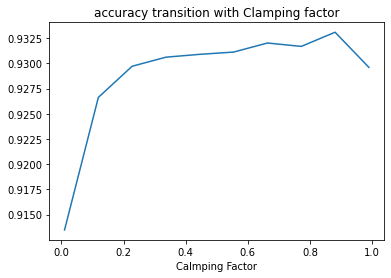

In [15]:
plt.plot(clamping_factors, mean_acc)
plt.xlabel('Calmping Factor')
plt.title("accuracy transition with Clamping factor")

結果より$\alpha = 0.8,0.9$あたりで良い性能を示していることがわかる.  
一般に$\alpha$の値が大きいと教師ラベルを絶対的に信用する挙動を示すのでノイズに対してロバスト出ない結果が出ることが推測される．  
今回のデータセットでは境界付近でラベルが混合している領域があり，そのようなデータが教師データとして選ばれた際に性能が低くなることが予想されるので$\alpha$の値が小さいときには比較的正答率が悪かったのだと考えられる．  
一方で一番右端の$\alpha = 0.99$の時はほとんど教師データを参考にしないという状況が起きているがために性能が少し下がったのだと考えられる．  
従って，$\alpha$の決め方はデータセットによる部分が大きく，上のようなハイパーパラメータ探索によって決めることが望ましいと言える．  

### 課題1(c). 近傍数（近傍半径）を変化させたときのAccuracy

### rbfカーネル

In [16]:
num_trial = 10
mean_accs = []
n_neighbors = np.arange(1,len(y))

mean_acc = np.zeros(len(n_neighbors))
for _ in range(num_trial):        
    y_semi = set_unlabeled_data(y, 0.1)
    for i,ng in enumerate(n_neighbors):
        ls = LabelSpreading(kernel='rbf', n_neighbors=ng, alpha=cf)
        ls.fit(X_pca, y_semi)
        y_pred = ls.predict(X_pca)
        acc = ls.score(X_pca, y)
        mean_acc[i] += acc
mean_acc /= num_trial

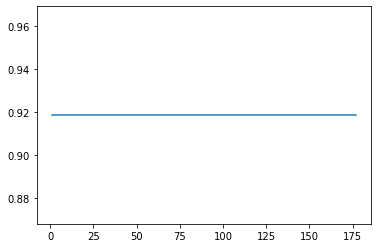

In [17]:
plt.plot(n_neighbors, mean_acc)

近傍数はknnに対してのパラメータなのでrbfカーネルに対して近傍数を変えても変化はない．  
従って上のグラフのように近傍数に依存しない直線のグラフが得られる．  
rbfではそれぞれの学習データを頂点とする重み付き完全グラフを考えているとみなせる．  

### knnカーネル

In [18]:
num_trial = 10
mean_accs = []
n_neighbors = np.arange(1,len(y))

pred_list = []
sm = []

mean_acc = np.zeros(len(n_neighbors))
for j in range(num_trial):        
    y_semi = set_unlabeled_data(y, 0.1)
    for i,ng in enumerate(n_neighbors):
        ls = LabelSpreading(kernel='knn', n_neighbors=ng, alpha=cf)
        ls.fit(X_pca, y_semi)
        y_pred = ls.predict(X_pca)
        acc = ls.score(X_pca, y)
        mean_acc[i] += acc
        if j == 0:
            pred_list.append(y_pred)
            sm = y_semi
mean_acc /= num_trial

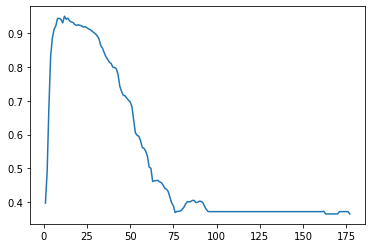

In [19]:
plt.plot(n_neighbors, mean_acc)

上のグラフより，近傍数が10付近で一番良い性能を出しており，75を超えたあたりから正答率40%の性能しか出せなくなっている．  
近傍数は局所的な情報と大域的な情報どちらを重要視するかのパラメータになっていたので，そのトレードオフが発生していると考えられる．  
近傍数を大きくしていった際の40%と言う数字は予測値としてデータセットの中の一番サンプル数が大きいクラスである1とした場合(何が来ても1と予測する予測器)の正答率と一致している．

In [20]:
len(pred_list)

177

In [21]:
from collections import Counter
Counter(y)

Counter({0: 59, 1: 71, 2: 48})

In [22]:
# 全部1と予測した際の正答率
max(Counter(y).values()) / len(y)

0.398876404494382

# 追加考察

上の実験において予測値の分布がどのように変化しているのかについての考察を行う． 

# 近傍数176

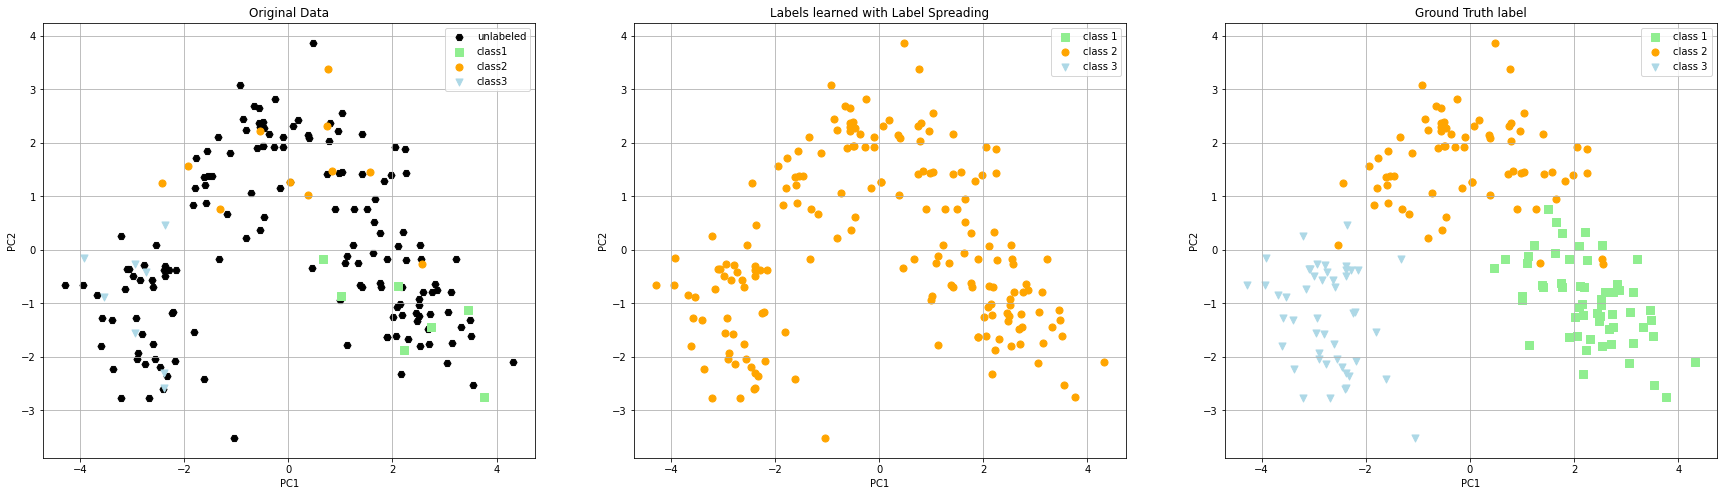

In [24]:
plot_ssl(pred_list[-1],sm)

全てのノードを近傍として考えているので，全てのデータ点に対して，半教師ありデータとしてラベルが最も多いclass2を予測結果とする予測器ができていることがわかる．

## 近傍数15

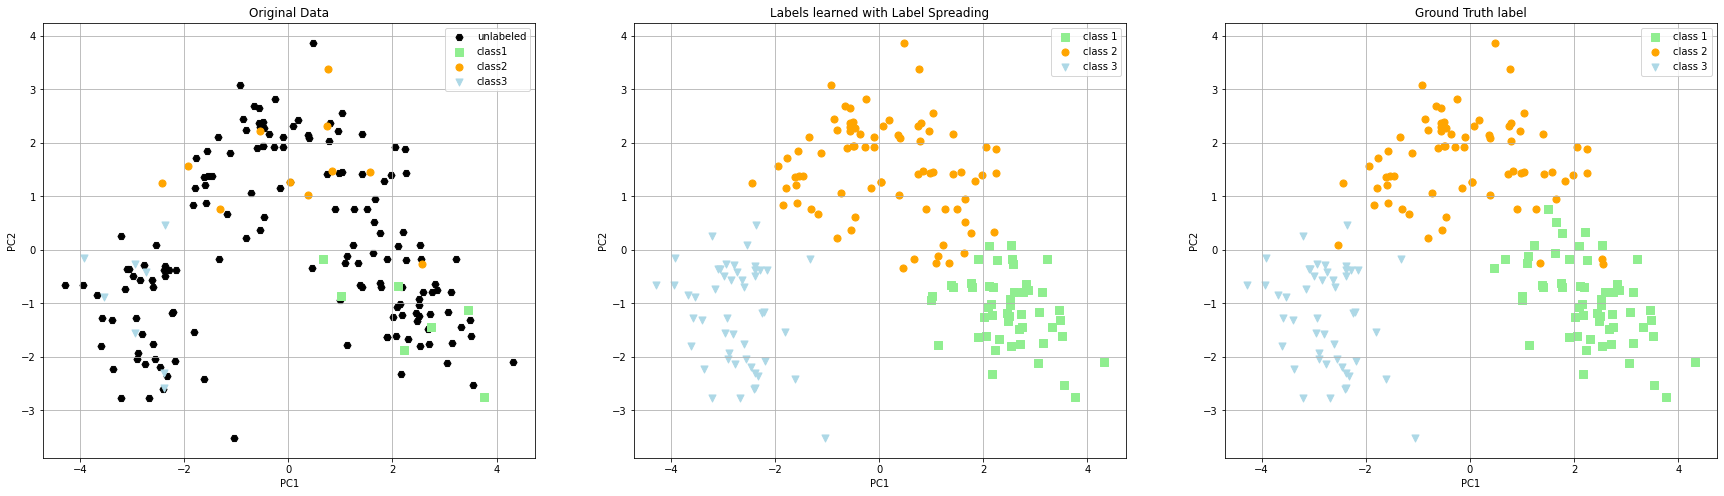

In [25]:
plot_ssl(pred_list[14],sm)

この時の近傍数は適切に設定されており，元のデータ分布をうまく近似するような予測ができていることが見て取れる．